In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



/kaggle/input/complaint-cfpb/complaints.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scp
%matplotlib inline
plt.rcParams['figure.figsize'] = 8,4
import warnings
warnings.filterwarnings('ignore')

from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.graph_objs as go

import plotly.express as px

In [3]:
df = pd.read_csv('/kaggle/input/complaint-cfpb/complaints.csv')

In [4]:
df.shape

(3190837, 18)

In [5]:
df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [6]:
#Clean column headers up
df.columns = ['DateReceived', 'Product', 'SubProduct', 'Issue','SubIssue','ConsumerComplaintNarrative', 
               'CompanyPublicResponse', 'Company', 'State', 'ZIPCode', 'Tags', 'ConsumerConsentProvided?',
               'SubmittedVia', 'DateSentToCompany', 'CompanyResponseToConsumer', 'TimelyResponse', 
               'ConsumerDisputed', 'ComplaintID']

drop_columns = ['Tags',
                'CompanyPublicResponse',
                'ConsumerConsentProvided?',
                'DateSentToCompany',
                'ComplaintID']

df = df.drop(drop_columns, 1) 

df.dtypes

DateReceived                  object
Product                       object
SubProduct                    object
Issue                         object
SubIssue                      object
ConsumerComplaintNarrative    object
Company                       object
State                         object
ZIPCode                       object
SubmittedVia                  object
CompanyResponseToConsumer     object
TimelyResponse                object
ConsumerDisputed              object
dtype: object

In [7]:
replacements = {'No': 0,
               'Yes': 1,
               'Untimely response' : 0,
               'Closed without relief': 0,
               'Closed' : 0,
               'Closed with explanation': 1,
               'Closed with non-monetary relief' : 1,
               'In progress' : np.nan,
               'Closed with relief': 1,
               'Closed with monetary relief' : 1}

df.replace(replacements, inplace = True)

In [8]:
total_of_complaints = df.shape[0]
total_of_closed_with_relief = (np.sum(df['CompanyResponseToConsumer'] == 1)/total_of_complaints)*100
total_of_closed_without_relief = (np.sum(df['CompanyResponseToConsumer'] == 0)/total_of_complaints)*100
print("Closed with relief:", round(total_of_closed_with_relief,2),"%")
print("Closed without relief:", round(total_of_closed_without_relief,2),"%")

Closed with relief: 96.32 %
Closed without relief: 1.41 %


In [9]:
categorical_variables = ['CompanyResponseToConsumer', 'TimelyResponse', 'ConsumerDisputed']
df[categorical_variables].apply(pd.Series.value_counts)

,CompanyResponseToConsumer,TimelyResponse,ConsumerDisputed
0.0,44876,50666,620062
1.0,3073395,3140171,148378


In [10]:
dfCCN = df[~df['ConsumerComplaintNarrative'].isnull()]
cat_variables = ['ConsumerComplaintNarrative']
dfCCN[cat_variables].shape # 331,077 instances

(1150291, 1)

In [11]:
dfCCN_sample = dfCCN[0:400]
dfCCN_sample_trans = dfCCN[0:400]
dfCCN_sample[cat_variables].shape

(400, 1)

In [13]:
dfCCN_sample['Complaint_Length'] = dfCCN_sample['ConsumerComplaintNarrative'].str.len()
maxClm = dfCCN_sample['Complaint_Length'].max()
maxClm

9415

In [15]:
# Index where 'Complaint_Length' is longest
idx = dfCCN_sample["ConsumerComplaintNarrative"].apply(len).idxmax()
print(idx)
# Get that row
#dfCCN["ConsumerComplaintNarrative"][2778559]

3630


**Emotion Detection using**
* NRCLex library

In [16]:
pip install NRCLex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 2.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43329 sha256=a6dbfcd6a27357cd68b1b1297d47cca6511ae8d2b444579735beeccdbba3c89e
  Stored in directory: /root/.cache/pip/wheels/af/2c/9c/dfa19d1b65326c520b32850a9311f6d4eda679ac04dba26081
Successfully built NRCLex
Note: you may need to restart the kernel to use updated packages.


In [17]:
from nrclex import NRCLex

In [18]:
text = 'We can do it'
text = NRCLex(text)
#Return affect dictionary
print(text.affect_dict)
#Return raw emotional counts
print("\n",text.raw_emotion_scores)
#Return highest emotions
print("\n", text.top_emotions)
#Return affect frequencies
print("\n",text.affect_frequencies)

{}

 {}

 [('fear', 0.0), ('anger', 0.0), ('anticip', 0.0), ('trust', 0.0), ('surprise', 0.0), ('positive', 0.0), ('negative', 0.0), ('sadness', 0.0), ('disgust', 0.0), ('joy', 0.0)]

 {'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 'trust': 0.0, 'surprise': 0.0, 'positive': 0.0, 'negative': 0.0, 'sadness': 0.0, 'disgust': 0.0, 'joy': 0.0}


**Installing transformer models**

In [21]:
! pip install transformers -q

In [22]:
from transformers import pipeline

# Used various models from huggingface 
### RoBERTa builds on BERT’s language masking strategy and identify emotions with 28 levels
link for the model: https://huggingface.co/arpanghoshal/EmoRoBERTa 
### Emotion English DistilRoBERTa-base model classify emotions in English text data. The modelpredicts Ekman's 6 basic emotions 
link: https://huggingface.co/j-hartmann/emotion-english-distilroberta-base)

In [28]:
Emotion_EmoRoBERTa = pipeline('sentiment-analysis', model='arpanghoshal/EmoRoBERTa')

Emotion_distilroberta = pipeline('sentiment-analysis', model="j-hartmann/emotion-english-distilroberta-base")

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [29]:
e_labels = Emotion_distilroberta("I'm sorry that the order got delayed")
e_labels

[{'label': 'sadness', 'score': 0.9476867914199829}]

In [30]:
emotion_labels = Emotion_EmoRoBERTa("I'm sorry that the order got delayed")
emotion_labels

[{'label': 'remorse', 'score': 0.7496777772903442}]

In [31]:
emotion_labels[0]['label']

'remorse'

# **Applying emotion on datafeame CFPB**

In [32]:
complaint_sample1 = dfCCN_sample["ConsumerComplaintNarrative"][24]
print(complaint_sample1)
len(complaint_sample1)

Hi Experian is reporting fraudulent inquires on my credit profile. My identity was compromised when I was out of town and my wallet was stolen. My ID and credit cards were taking. The items that are on my report need to be removed because I can't get approved for future lines credit. I had sent a complaint out previous but my all my inquiries listed did not get removed from my credit profile


394

In [33]:
dfCCN_sample["ConsumerComplaintNarrative"][1:10].apply(Emotion_EmoRoBERTa, truncation=True)

1      [{'label': 'realization', 'score': 0.979359745...
2      [{'label': 'neutral', 'score': 0.7483665943145...
14     [{'label': 'neutral', 'score': 0.9020510315895...
24     [{'label': 'approval', 'score': 0.726227223873...
41     [{'label': 'realization', 'score': 0.663544595...
184    [{'label': 'disapproval', 'score': 0.806851446...
246    [{'label': 'approval', 'score': 0.979438781738...
251    [{'label': 'confusion', 'score': 0.93486738204...
261    [{'label': 'neutral', 'score': 0.9807001352310...
Name: ConsumerComplaintNarrative, dtype: object

In [34]:
dfCCN_sample["ConsumerComplaintNarrative"][1:10].apply(Emotion_distilroberta, truncation=True)

1      [{'label': 'neutral', 'score': 0.6965498328208...
2      [{'label': 'anger', 'score': 0.4907619059085846}]
14     [{'label': 'sadness', 'score': 0.9363564848899...
24     [{'label': 'anger', 'score': 0.4878622591495514}]
41     [{'label': 'sadness', 'score': 0.4518370032310...
184    [{'label': 'neutral', 'score': 0.39273801445961}]
246    [{'label': 'anger', 'score': 0.5735880136489868}]
251    [{'label': 'neutral', 'score': 0.5996018052101...
261    [{'label': 'anger', 'score': 0.5208485722541809}]
Name: ConsumerComplaintNarrative, dtype: object

In [35]:
#Function to obtain emotion from Emotion_EmoRoBERTa while passing text
def get_elabel_EmoRoBERTa(text):
  return(Emotion_EmoRoBERTa(text, truncation=True)[0]['label'])

In [36]:
#Function to obtain emotion from Emotion_distilroberta while passing text
def get_elabel_distilroberta(text):
  return(Emotion_distilroberta(text, truncation=True)[0]['label'])

In [37]:
get_elabel_EmoRoBERTa("India played very well and the fans were amused")

'amusement'

In [38]:
get_elabel_distilroberta("India played very well and the fans were amused")

'joy'

In [39]:
dfCCN_sample['emotion_label'] = dfCCN_sample["ConsumerComplaintNarrative"].apply(get_elabel_distilroberta)

In [45]:
dfCCN_sample['emo_label'] = dfCCN_sample["ConsumerComplaintNarrative"].apply(get_elabel_EmoRoBERTa)

In [46]:
dfCCN_sample.head(2)

,DateReceived,Product,SubProduct,Issue,SubIssue,ConsumerComplaintNarrative,Company,State,ZIPCode,SubmittedVia,CompanyResponseToConsumer,TimelyResponse,ConsumerDisputed,Complaint_Length,emotion_label,emo_label
0,2022-12-18,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,still showing an account that should have been...,Experian Information Solutions Inc.,FL,33685.0,Web,1.0,1,NaN,439,sadness,neutral
1,2022-11-07,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,I discovered that some of the information on m...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,10469.0,Web,1.0,1,NaN,669,neutral,realization


In [47]:
import seaborn as sns

Text(0.5, 1.0, 'Emotion Distribution')

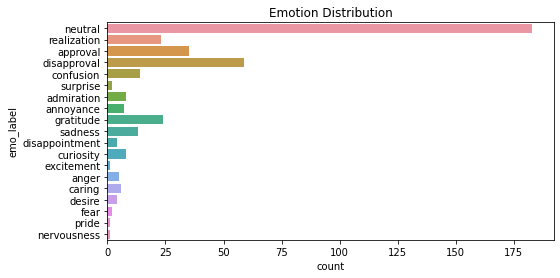

In [48]:
sns.countplot(data = dfCCN_sample, y = 'emo_label').set_title("Emotion Distribution")

Text(0.5, 1.0, 'Emotion Distribution')

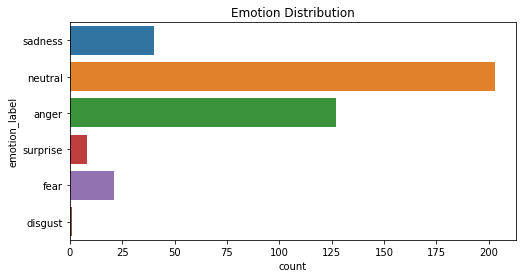

In [41]:
sns.countplot(data = dfCCN_sample, y = 'emotion_label').set_title("Emotion Distribution")